# Background

Links:
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [BayesSearchCV Docs Example](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Categorical, Integer
from time import time

plt.style.use("../style.mplstyle")
%matplotlib inline

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
n_samples = 20000
X, y = data.iloc[:n_samples, :-1].values, data.iloc[:n_samples, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 20000
Number of features        : 11
Count of positive outcomes: 9861 (49.3%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
84944,18102,1,165,78.0,120,80,1,1,0,0,1,0
93727,16187,2,172,88.0,120,80,2,2,1,0,1,1
69036,18784,2,175,82.0,120,80,1,1,0,0,1,0
18032,20504,1,158,57.0,120,70,1,1,0,0,1,0
34048,19665,1,155,78.0,140,90,1,1,0,0,1,1
95896,22583,1,150,57.0,130,80,1,1,0,0,1,1
16135,15140,1,157,80.0,160,90,2,1,0,0,1,1
52540,18801,1,168,69.0,130,80,1,1,0,0,1,0
32096,15209,1,162,56.0,160,100,1,1,0,0,1,1


In [3]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
model = RandomForestClassifier(random_state=42)

## BayesSearchCV

In [4]:
start = time()

opt = BayesSearchCV(
    model,
    {
        "max_depth": Integer(5, 250),
        "min_samples_leaf": Integer(1, 50),
        "criterion": Categorical(["gini", "entropy"]),
    },
    n_iter=512,
    cv=cv,
    n_jobs=1,
    random_state=42,
    scoring="roc_auc",
)
print(f"Number of iterations: {opt.total_iterations}")  # n_iter * 3

best_score, iteration = 0, 0
# callback handler
def on_step(optim_result):
    global best_score
    global iteration
    iteration += 1
    score = opt.best_score_
    if score > best_score:
        best_score = score
        print(f"\nBest score (iteration): {best_score:.4f} ({iteration})")
    elif iteration % 10 == 0:
        print(
            f"Iteration {iteration}, runtime {(time() - start) / 60:.1f} minutes...",
            end="\r",
        )

opt.fit(X_train, y_train, callback=on_step)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt.best_score_:.4f}")
print(f"Test score     : {opt.score(X_test, y_test):.4f}")
print("Best parameters:")
for item in opt.best_params_.items():
    print(f"\t{item}")

Number of iterations: 1536

Best score (iteration): 0.7983 (1)

Best score (iteration): 0.7984 (4)

Best score (iteration): 0.7985 (10)
Iteration 20, runtime 11.5 minutes...
Best score (iteration): 0.7986 (21)
Iteration 60, runtime 31.5 minutes...
Best score (iteration): 0.7988 (66)
Iteration 70, runtime 35.8 minutes...
Best score (iteration): 0.7988 (75)
Iteration 510, runtime 416.1 minutes...
Run time     : 419.1 minutes
Best score     : 0.7988
Test score     : 0.7932
Best parameters:
	('criterion', 'entropy')
	('max_depth', 250)
	('min_samples_leaf', 26)


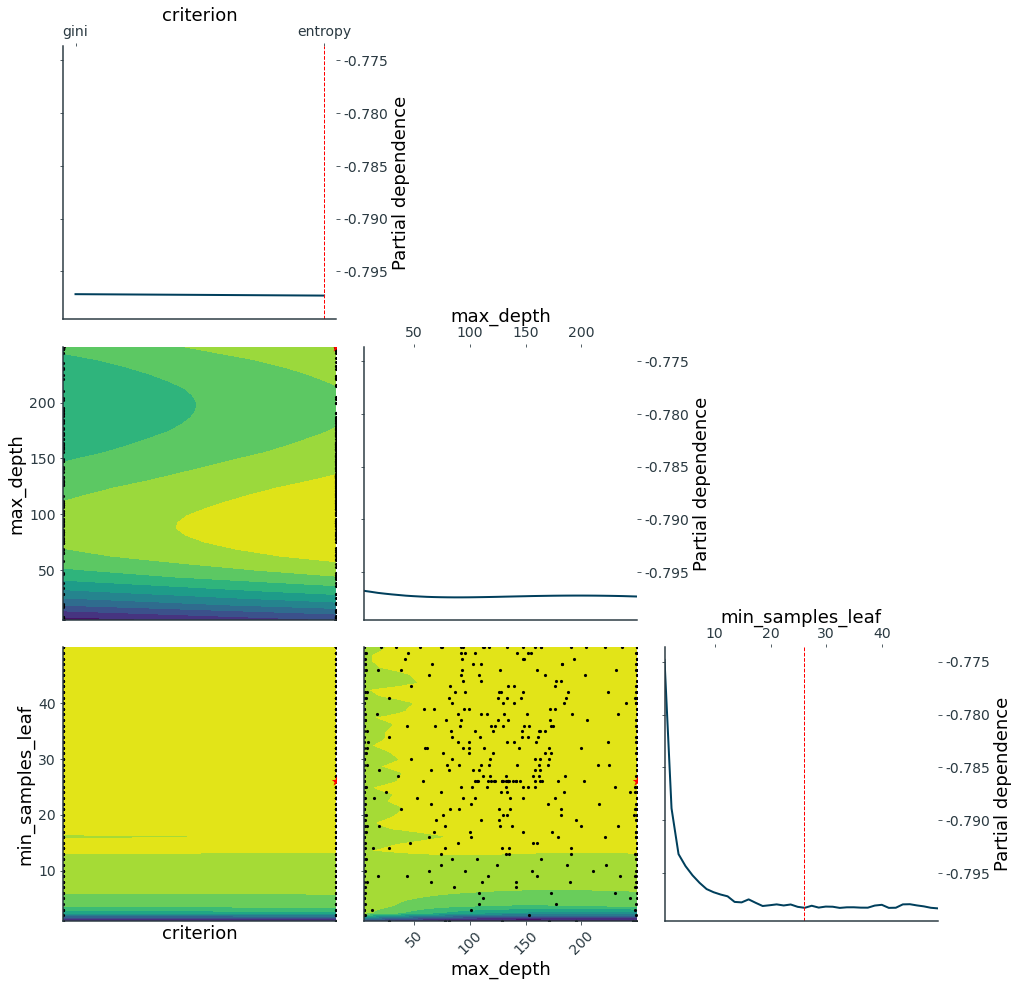

In [6]:
_ = plot_objective(
    opt.optimizer_results_[0],
    dimensions = ["criterion", "max_depth", "min_samples_leaf"],
    n_minimum_search=int(1e8),
    size=4.5,
)

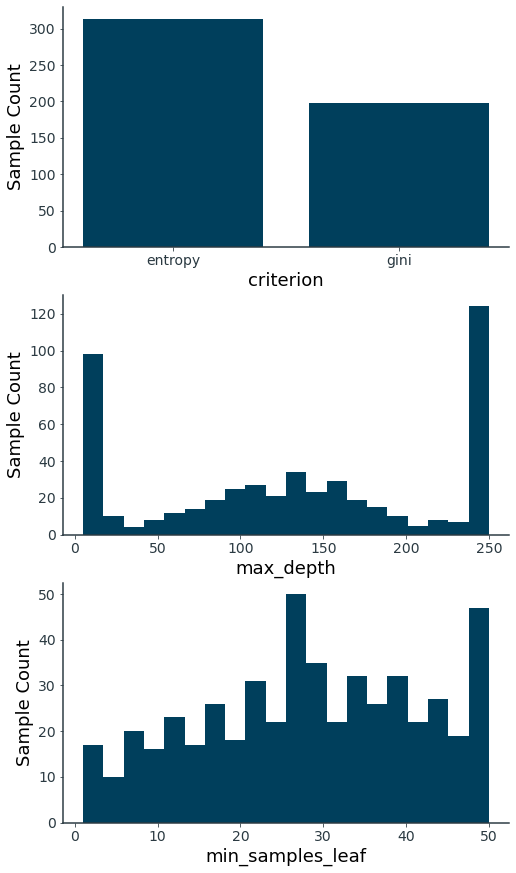

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(8, 15))
for i in range(3):
    plot_histogram(opt.optimizer_results_[0], i, ax=ax[i])